# Getting started with Task 1

Instructions:
- Download the dataset from the [ECG Heartbeat Categorization Dataset](https://www.kaggle.com/datasets/shayanfazeli/heartbeat)
- Unzip the `archive.zip` file
- Rename the folder `archive` as `ecg_dataset` and place it in the root of the git repository

References:
- [ECG Heartbeat Classification: A Deep Transferable Representation](https://arxiv.org/pdf/1805.00794.pdf)

## Load dependencies

In [51]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.regularizers import l1, l2
#from scikeras.wrappers import KerasClassifier
from keras.optimizers import SGD
import time

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.12.0
Num GPUs Available:  1


In [56]:
import torch
import numpy as np
import os
import sklearn
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score,roc_curve, auc

from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans

#pd.set_option('display.max_rows', None)
#print('libraries imported!')

print('libraries imported!')

libraries imported!


## The PTB Diagnostic ECG Database

- Number of Samples: 14552
- Number of Categories: 2
- Sampling Frequency: 125Hz
- Data Source: Physionet's PTB Diagnostic Database
- ECG lead II re-sampled to the sampling frequency of 125Hz as the input (from [ECG Heartbeat Classification: A Deep Transferable Representation](https://arxiv.org/pdf/1805.00794.pdf))
- Remark: All the samples are cropped, downsampled and padded with zeroes if necessary to the fixed dimension of 188.
- The final element of each row denotes the class to which that example belongs.


In [6]:
df_ptbd_normal = pd.read_csv("../ecg_dataset/ptbdb_normal.csv", header = None)
df_ptbd_abnormal = pd.read_csv("../ecg_dataset/ptbdb_abnormal.csv", header = None)

# print shapes of the dataframes
print("The shape of the normal dataframe is : ", df_ptbd_normal.shape)
# print one example of the last column
print("Class : ", df_ptbd_normal.iloc[:, -1][0])

print("The shape of the abnormal dataframe is : ", df_ptbd_abnormal.shape)
# print one example of the last column
print("Class : ", df_ptbd_abnormal.iloc[:, -1][0])


# classes are 0 (normal) and 1 (abnormal)
classes_names = {0 : "normal", 
                 1 : "abnormal"}

# get the number of columns in the dataframe
# the last column is the label/class
num_cols = df_ptbd_normal.shape[1] - 1 

# the signal was resampled at frequency of 125Hz as the input
# compute the time vector


The shape of the normal dataframe is :  (4046, 188)
Class :  0.0
The shape of the abnormal dataframe is :  (10506, 188)
Class :  1.0


The last time value is :  1488.0


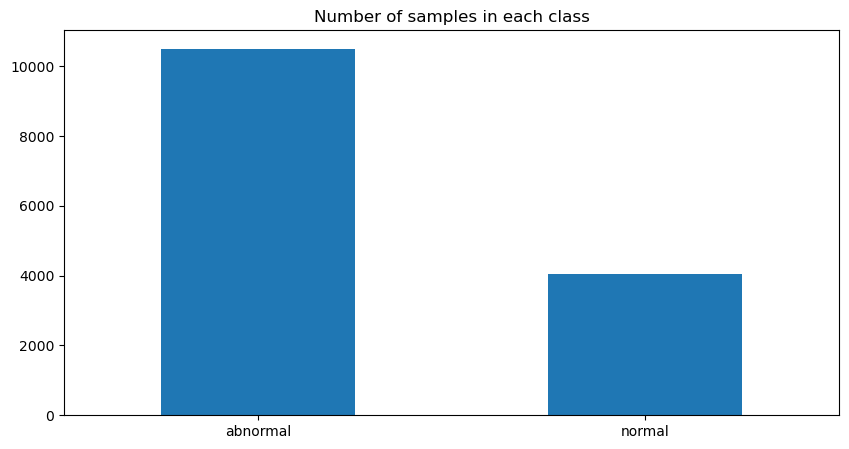

In [7]:
time = np.arange(0, num_cols) / 125
# convert to milliseconds
time = time * 1000
# print last time value
print("The last time value is : ", time[-1])

# for the first "num_cols" and the time steps as column names
df_ptbd_normal.columns = list(time) + ["label"]
df_ptbd_abnormal.columns = list(time) + ["label"]
# concatenate the two dataframes
df_ptbd = pd.concat([df_ptbd_normal, df_ptbd_abnormal], axis = 0)
df_ptbd_original = df_ptbd.copy()

# count the number of samples in each class and plot a bar chart
# change the class names to "normal" and "abnormal"
# count the number of samples in each class
counts = df_ptbd["label"].value_counts()
# substitute the class names: 0.0 -> normal, 1.0 -> abnormal
counts.index = counts.index.map(classes_names)

# create a figure 
plt.figure(figsize = (10, 5))
# plot a bar chart
counts.plot(kind = "bar")
# plot xticks in angle
plt.xticks(rotation = 0)
plt.title("Number of samples in each class")
plt.show()

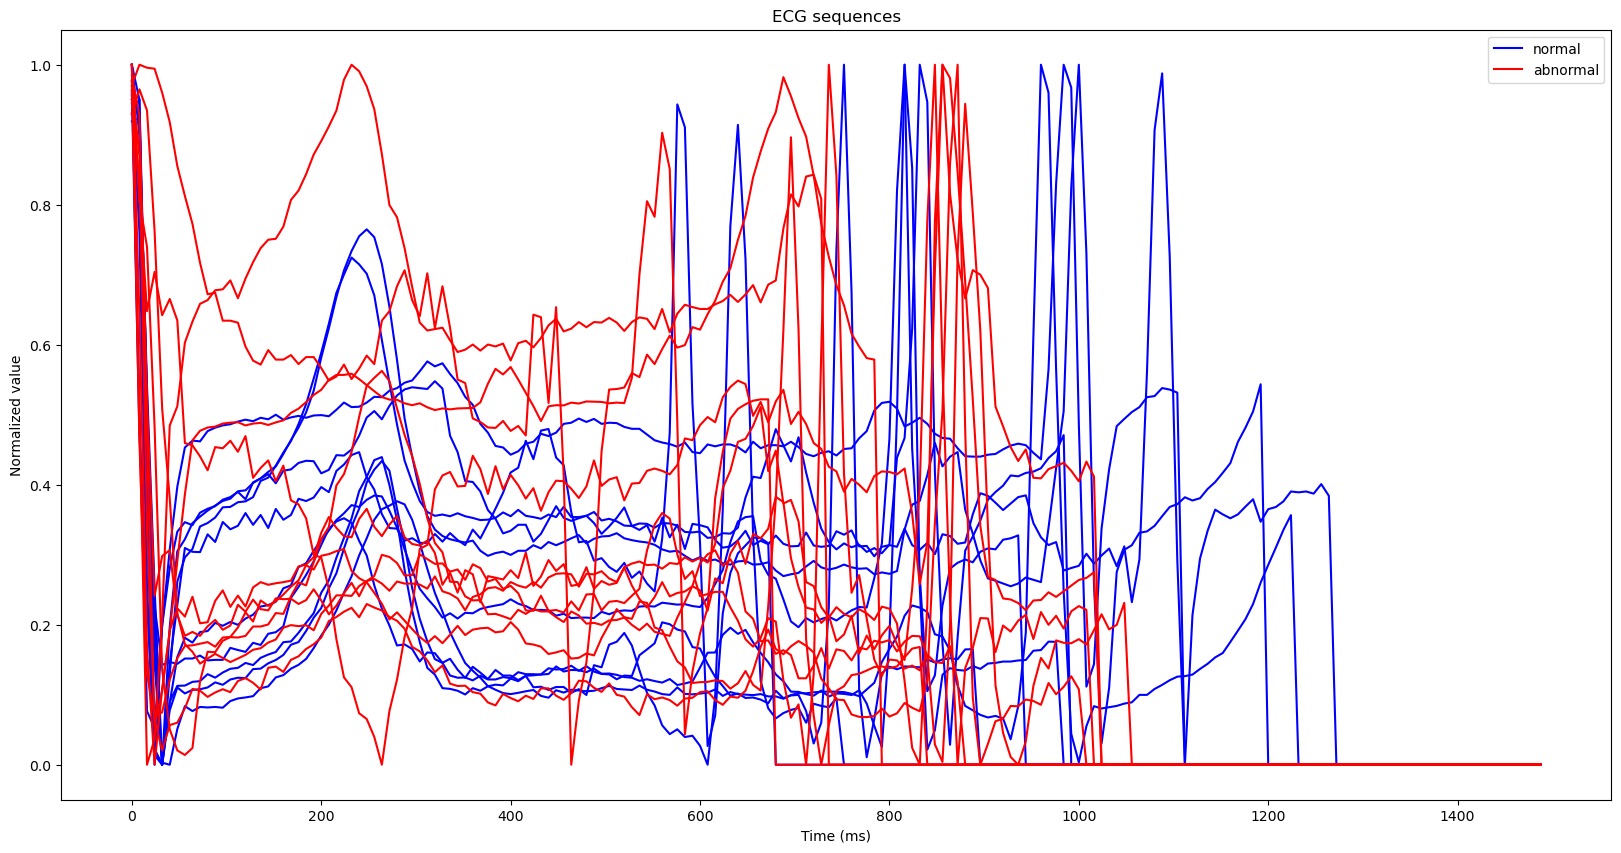

In [8]:
# plot a a row of the dataframe
# select 10 random sequences with class 0 (normal) and 10 with class 1 (abnormal)
df_ptbd_normal = df_ptbd[df_ptbd["label"] == 0].sample(10)
df_ptbd_abnormal = df_ptbd[df_ptbd["label"] == 1].sample(10)

df_ptbd_normal_np,df_ptbd_abnormal_np = np.array(df_ptbd_normal),np.array(df_ptbd_abnormal)

# create a figure
plt.figure(figsize = (20, 10))
# plot againts the column names (time)
# plot the normal sequences


for i in range(df_ptbd_normal.shape[0]):
    
    Yy,Xx = np.reshape(df_ptbd_normal_np[i, 0:-1],(187,1)),np.reshape(df_ptbd_normal.columns[:-1],(187,1))
    if i == 0:
        plt.plot(Xx, Yy, color = "blue", label = "normal")
    else:
        plt.plot(Xx, Yy,color = "blue")
        
# plot the abnormal sequences
for i in range(df_ptbd_abnormal.shape[0]):
    
    Yy,Xx =np.reshape(df_ptbd_abnormal_np[i, 0:-1],(187,1)),np.reshape(df_ptbd_abnormal.columns[:-1],(187,1))
    
    if i == 0:
        plt.plot(Xx,Yy, color = "red", label = "abnormal")
    else:   
        plt.plot(Xx, Yy, color = "red")
# create a legend for the plot, blue for normal and red for abnormal
plt.legend()
# set the title
plt.title("ECG sequences")
# y lable is "Normalized value"
plt.ylabel("Normalized value")
# x label is "Time (ms)"
plt.xlabel("Time (ms)")
# show the plot
plt.show()
# close
plt.close()

### Running a simple decision tree gradient boosting regressor

In [9]:

import time

# Now run a simple decision tree algorithm as well as L-1 regularized model to see predictor variables acting as strong
def decision_tree_classifier(X_train,X_test,Y_train,Y_test,cfr='DecisionTree',pca=False):
    start_time = time.time()
    if cfr == 'DecisionTree':
        print('Performing Decision Tree Classification with hyper-parameter tuning and cross-validation (5): ... ')
        classifier = DecisionTreeClassifier()
        param_grid = {
                      'criterion':['entropy'],
                      'max_depth':[3,5,10,None],
                      'min_samples_split':[5,10,15],
                      'min_samples_leaf':[1,5,10],
                      'class_weight' : ['balanced'],
                      'max_leaf_nodes':[None,10,50]}
        
        param_grid = {'class_weight': ['balanced'], 
                      'criterion': ['entropy'], 
                      'max_depth': [3], 
                      'max_leaf_nodes': [None], 
                      'min_samples_leaf': [1], 
                      'min_samples_split': [5]}
        
    elif cfr == 'GradientBoosting':
        print('Performing Gradient Boosting Regression with hyper-parameter tuning and cross-validation (5): ... ')
        classifier = GradientBoostingClassifier()
        param_grid = {'learning_rate':[0.1,1,10],
#                       #'n_estimators': [50, 100, 200, 500],
#                       #'subsample': [0.6, 0.8, 1.0],
#                       #'max_features':["auto", "sqrt", "log2", None],
                        'min_samples_leaf':[1,5,10,20],
                        'min_samples_split':[5,10,15,20], #introduce lower values 06/08
                       'max_depth':[3,5,10,20,None]
                      } 
        
    GridSearch = GridSearchCV(classifier,param_grid,cv=5) #hyperparameter tuning 
    GridSearch.fit(X_train,Y_train)
    best_params = GridSearch.best_params_
    best_score = GridSearch.best_score_
    best_model = GridSearch.best_estimator_
     
        
    print(f"Best parameters: {best_params}")
    print(f"Best score: {best_score}")
    
    best_model.fit(X_train, Y_train)

    y_pred = best_model.predict(X_train)
    score = accuracy_score(y_pred,Y_train)
    print("Train Score:", score)
   
    y_pred = best_model.predict(X_test)
    score = accuracy_score(y_pred,Y_test)
    print("Test Score:", score)

#     importances = best_model.feature_importances_
#     indices = np.argsort(importances)[::-1]

#     if not pca:
#         # Plotting Feature Importance
#         plt.figure(figsize=[20,10])
#         plt.title("Feature Importances")
#         plt.bar(range(X_train_imputed_norm.shape[1]), importances[indices], align="center")
#         plt.xticks(range(X_train_imputed_norm.shape[1]), X_train_imputed_norm.columns[indices], rotation=90)
#         plt.xlim([-1, X.shape[1]])
#         plt.show()
    
    print(f"{cfr} complete in {time.time()-start_time} seconds!")
    return score #for now


In [38]:
Y = df_ptbd['label']
X = df_ptbd.drop('label',axis=1)
X = np.array(X)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
Y_train,Y_test = np.array(Y_train),np.array(Y_test)
Y_train = np.reshape(Y_train,(Y_train.shape[0],1))
Y_test = np.reshape(Y_test,(Y_test.shape[0],1))
#final_score = decision_tree_classifier(X_train,X_test,Y_train,Y_test,cfr='GradientBoosting',pca=False)

### Trying this out with Deep Neural Networks


In [53]:
# Define NN
model = Sequential()
model.add(Dense(X_train.shape[0], input_dim=(X_train.shape[1]), activation='relu'))#, kernel_regularizer=l2(1)))
#model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))#, kernel_regularizer=l2(1))) 
#model.add(Dropout(0.2))
model.add(Dense(30, activation='relu'))#, kernel_regularizer=l2(1))) 
#model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid')) 

sgd = SGD(learning_rate=0.01,momentum=0.9)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy']) 


# Fit and predict with NN
print(f"Training Neural Network:")
start_time = time.time()
model.fit(X_train, Y_train, epochs=200, batch_size=50, verbose=0)
print(f"Model Trained in {time.time()-start_time} seconds")

/usr/workspace/azhar2/.conda/envs/python3.9/lib/python3.9/site-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Training Neural Network:
Model Trained in 122.04488921165466 seconds


In [54]:
from sklearn.metrics import accuracy_score
yhat_train = model.predict(X_train)
yhat_train = np.round(yhat_train)
#yhat_train = np.argmax(yhat_train,axis=1)
print(f"Train Set Accuracy: {accuracy_score(yhat_train,Y_train)}\n")

yhat_test = model.predict(X_test)
yhat_test = np.round(yhat_test)
#yhat_test = np.argmax(yhat_test,axis=1)
print(f"Test Set Accuracy: {accuracy_score(yhat_test,Y_test)}")

364/364 [==============================] - 0s 1ms/step
Train Set Accuracy: 1.0

91/91 [==============================] - 0s 1ms/step
Test Set Accuracy: 0.9811061490896599


In [59]:
print("Test Set Metrics: ")

print(f"Test Set Accuracy: {accuracy_score(yhat_test,Y_test)}")

precision = precision_score(yhat_test,Y_test)
print(f"Precision Score: {precision}")

recall = recall_score(yhat_test,Y_test)
print(f"Recall Score: {recall}")

f1 = f1_score(yhat_test,Y_test)
print(f"F1 Score: {f1}")

Test Set Metrics: 
Test Set Accuracy: 0.9811061490896599
Precision Score: 0.9889263360616274
Recall Score: 0.9846596356663471
F1 Score: 0.9867883737689167


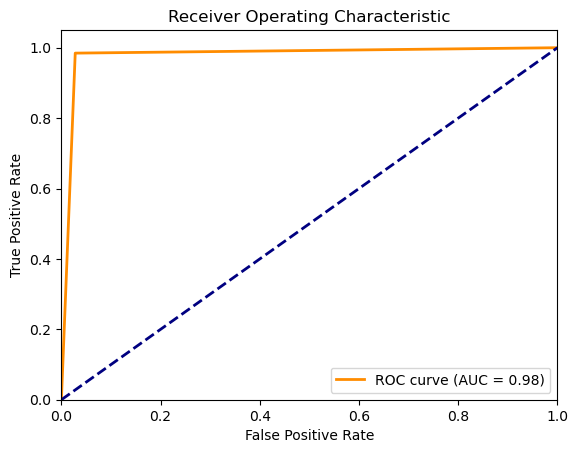

In [58]:
# Plotting ROC CURVE:
fpr, tpr, thresholds = roc_curve(yhat_test, Y_test)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()